In [1]:
# %env LC_ALL=C.UTF-8
# %env LANG=C.UTF-8
# %env TRANSFORMERS_CACHE=/content/cache
# %env HF_DATASETS_CACHE=/content/cache
# %env CUDA_LAUNCH_BLOCKING=1

In [6]:
import torch
from importlib import reload

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import ctc_decoders

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

seed_everything(42)

Global seed set to 42


42

In [7]:
alphas = np.linspace(0, 1, 100)
betas = np.linspace(0, 1, 100)

df = pd.read_csv('beam_lm_alpha_beta_all.csv')
df.head()

,alpha,beta,cer
0,0.0,0.0,0.526596
1,0.0,1.0,0.526596
2,0.0,2.0,0.526596
3,0.0,3.0,0.526596
4,0.0,4.0,0.526596


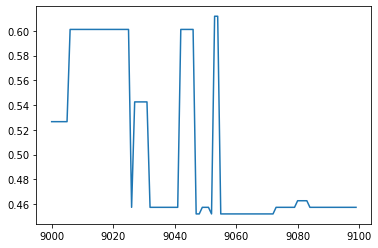

In [13]:
plt.plot(df[df['alpha'] == 90]['cer'])
plt.show()

## Tokenizer

In [2]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer(
    "./fa-vocab.json", 
    bos_token="<s>",
    eos_token="</s>",
    unk_token="<unk>",
    pad_token="<pad>",
    word_delimiter_token="|",
    do_lower_case=False
)

In [4]:
list(tokenizer.get_vocab().keys())

['<pad>',
 '<s>',
 '</s>',
 '<unk>',
 '|',
 'ب',
 'ی',
 'غ',
 'ش',
 'آ',
 'ت',
 'خ',
 'پ',
 'ض',
 'ژ',
 'ئ',
 'ر',
 'ن',
 'ل',
 'س',
 'ء',
 'چ',
 'ح',
 'ط',
 'ظ',
 'گ',
 'ک',
 'و',
 'ذ',
 'د',
 'ف',
 'ق',
 'ج',
 'ا',
 'ث',
 'ص',
 'ه',
 'ز',
 'م',
 'ع']

In [3]:
text = "از مهمونداری کنار بکشم"
print(" ".join(tokenizer.tokenize(text)))
print(tokenizer.decode(tokenizer.encode(text)))

ا ز | م ه م و ن د ا ر ی | ک ن ا ر | ب ک ش م
از مهمونداری کنار بکشم


## Feature Extractor

In [4]:
from transformers import Wav2Vec2FeatureExtractor


feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, 
                                             sampling_rate=16000, 
                                             padding_value=0.0, 
                                             do_normalize=True, 
                                             return_attention_mask=True)

## Processor

In [5]:
from transformers import Wav2Vec2Processor


processor = Wav2Vec2Processor(feature_extractor=feature_extractor, 
                              tokenizer=tokenizer)

In [6]:
if len(processor.tokenizer.get_vocab()) == len(processor.tokenizer):
    print(len(processor.tokenizer))

40


In [7]:
processor.save_pretrained('processor/')

## Dataset

In [8]:
# data_dir = 'cv-fa-6.1/cv-corpus-6.1-2020-12-11/fa/'
# data_dir = 'shemo-fa/'
data_dir = 'medical_data/'
csv_dir = '/media/data/soroosh/dataset/ASR/' + data_dir

import src.data
reload(src.data)
from src.data import DataModule

data_module = DataModule(processor, csv_dir, min_dur=1, max_dur=10, batch_size=2)
data_module.setup()

2575 samples with 9 hours, 40 minutes, 26 seconds audio were filtered.
num samples: 6335  total duration: 10 hours, 54 minutes, 12 seconds
num samples: 991  total duration: 2 hours, 17 minutes, 58 seconds
num train samples: 6335  total duration: 10 hours, 54 minutes, 12 seconds
num val samples: 991  total duration: 2 hours, 17 minutes, 58 seconds


In [10]:
# x,y = data_module.train[0]
# x.shape, len(y)

In [11]:
# b = next(iter(data_module.train_dataloader()))
# for k, v in b.items():
#     print(k, v.shape)

## Model

In [12]:
import src.wav2vec
reload(src.wav2vec)
from src.wav2vec import Wav2vec

model = Wav2vec(processor, max_epochs=10)
# model = Wav2vec.load_from_checkpoint('weights/cv/epoch=4-val_loss=0.10.ckpt', processor=processor, lr=1e-5)

In [14]:
model.count_parameters()

In [13]:
# model.step(b)

## Trainer

In [15]:
# default logger used by trainer
logger = TensorBoardLogger(
    save_dir='logs/',
    name='shemo',
)

checkpoint = ModelCheckpoint(dirpath='weights/shemo/', 
                             filename='{epoch}-{val_loss:.2f}', 
                             monitor='val_loss',
                             save_top_k=1, 
                             period=1)

lr_logger = LearningRateMonitor(logging_interval='step')

trainer = Trainer(benchmark=True, 
                  gpus=1, 
                  logger=logger, 
                  max_epochs=10,
                  callbacks=[checkpoint, lr_logger])

### Training

In case you want to use this google colab to fine-tune your model, you should make sure that your training doesn't stop due to inactivity. A simple hack to prevent this is to paste the following code into the console of this tab (*right mouse click -> inspect -> Console tab and insert code*).

```javascript
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
```

In [16]:
trainer.fit(model, data_module)

In [17]:
trainer.save_checkpoint('weights/shemo/last.ckpt')

## Evaluate

In [ ]:
model_test.transcribe('test.wav')